In [50]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from datetime import date,timedelta
import datetime as dt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [6]:
df = pd.read_csv("Cramers Picks (2016 to 2022) Performance v2.csv")

In [24]:
df["Date"] = pd.to_datetime(df["Date"])
df["Call"] = df["Call"].replace("Buy", 2)
df["Call"] = df["Call"].replace("Sell", -2)
df["Call"] = df["Call"].replace("Positive Mention", 1)
df["Call"] = df["Call"].replace("Negative Mention", -1)
df["Call"] = df["Call"].replace("Hold", 0)
df["Date"] = df["Date"].dt.strftime("%Y-%m-%d")
df

,S.No,Company,Ticker,Date,Call,1-Day Change Recommendation,1-Week Change Recommendation,1-Month Change Recommendation,1-Year Change Recommendation,1-Day Change Benchmark,1-Week Change Benchmark,1-Month Change Benchmark,1-Year Change Benchmark
0,1,Lululemon Athletica,LULU,2018-03-27,1,2.0%,2.7%,15.4%,95%,-0.4%,1.4%,3%,10%
1,2,Penn National Gaming,PENN,2020-07-14,2,10.3%,4.4%,52.5%,100%,-0.2%,1.6%,5%,37%
2,3,Simon Property Group,SPG,2020-11-13,2,-1.2%,8.2%,10.6%,121%,0.4%,-1.4%,1%,31%
3,4,PVH Corp,PVH,2016-05-25,2,-2.5%,3.8%,-9.4%,13%,0.0%,0.7%,-4%,18%
4,5,Broadcom,AVGO,2016-06-02,1,-1.9%,-1.1%,-7.0%,58%,0.0%,-0.1%,0%,18%
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21649,21650,Not Available,F,2022-11-22,-1,0.2%,-0.9%,-19.0%,NaN,NaN,NaN,NaN,NaN
21650,21651,Not Available,EL,2022-11-22,2,-0.1%,6.2%,8.6%,NaN,NaN,NaN,NaN,NaN
21651,21652,Not Available,SHOP,2022-11-22,1,4.0%,11.2%,-8.3%,NaN,NaN,NaN,NaN,NaN
21652,21653,Not Available,IMGN,2022-11-22,-1,-3.2%,0.6%,-9.7%,NaN,NaN,NaN,NaN,NaN


In [8]:
stocks = {}

In [44]:
def JimOverTime(tick):
    stocks[tick] = yf.download(tick, period="max", interval="1d")
    stocks[tick]["date"] = stocks[tick].index
    stocks[tick]["index"] = range(len(stocks[tick]))
    pd.to_datetime(stocks[tick]["date"])
    stocks[tick].set_index("index")
    stocks[tick].index = pd.to_datetime(stocks[tick].index)
    stocks[tick]["date"]=stocks[tick]["date"].dt.date
    stocks[tick]["date"] = pd.to_datetime(stocks[tick]["date"])
    stocks[tick]["date"].tz_localize(None)
    stocks[tick]["date"] = stocks[tick]["date"].dt.strftime("%Y-%m-%d")

    date = []
    call = []
    price = []
    volume = []

    date = pd.date_range(start=pd.to_datetime('2016-01-01'), end=pd.to_datetime('2023-01-01'), freq='D')
    date = date.strftime("%Y-%m-%d")

    date = list(date)

    for i in date:
        if i in list(df[df["Ticker"] == tick]["Date"]):
            price.append(stocks[tick][stocks[tick]["date"] == i]["Close"].to_numpy())
            volume.append(stocks[tick][stocks[tick]["date"] == i]["Volume"].to_numpy())
            call.append(df.loc[(df["Ticker"] == tick) & (df["Date"] == i)]["Call"].to_numpy())
        else:
            call.append(None)
            price.append(stocks[tick][stocks[tick]["date"] == i]["Close"].to_numpy())
            volume.append(stocks[tick][stocks[tick]["date"] == i]["Volume"].to_numpy())

    _df = {"date": date,
           "price": price,
           "volume": volume,
           "call": call}
    _df = pd.DataFrame(_df)
    _df = _df[_df["price"] != 0]
    return _df


In [26]:
LuLuJim = JimOverTime("LULU")
LuLuJim


[*********************100%***********************]  1 of 1 completed


,date,price,volume,call
3,2016-01-04,[[55.86000061035156]],[[7252300]],None
4,2016-01-05,[[55.59000015258789]],[[3139700]],None
5,2016-01-06,[[54.90999984741211]],[[2776900]],None
6,2016-01-07,[[54.790000915527344]],[[4041300]],None
7,2016-01-08,[[53.90999984741211]],[[3170900]],None
...,...,...,...,...
2548,2022-12-23,[[311.5400085449219]],[[933500]],None
2552,2022-12-27,[[315.0400085449219]],[[1287900]],None
2553,2022-12-28,[[308.9599914550781]],[[1458200]],None
2554,2022-12-29,[[316.82000732421875]],[[936000]],None


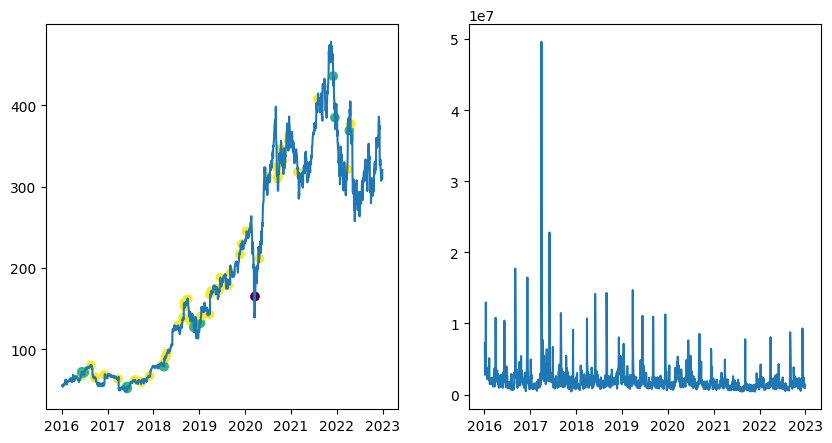

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(pd.to_datetime(LuLuJim["date"]),LuLuJim["price"],label="Price")
plt.scatter(pd.to_datetime(LuLuJim.dropna()["date"]),LuLuJim.dropna()["price"],c=LuLuJim.dropna()["call"])
plt.subplot(1, 2, 2)
plt.plot(pd.to_datetime(LuLuJim["date"]),LuLuJim["volume"],label="Volume")
plt.show()


In [42]:
def jimOverTimePlot(df): 
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(pd.to_datetime(df["date"]),df["price"],label="Price")
    plt.scatter(pd.to_datetime(df.dropna()["date"]),df.dropna()["price"],c=df.dropna()["call"])
    plt.subplot(1, 2, 2)
    plt.plot(pd.to_datetime(df["date"]),df["volume"],label="Volume")
    plt.show()


In [61]:
dfS = JimOverTime("SPG")

[*********************100%***********************]  1 of 1 completed


In [62]:
dfS

,date,price,volume,call
3,2016-01-04,[[192.33999633789062]],[[1445500]],None
4,2016-01-05,[[196.1699981689453]],[[1236500]],None
5,2016-01-06,[[195.69000244140625]],[[941800]],None
6,2016-01-07,[[191.55999755859375]],[[1285800]],None
7,2016-01-08,[[186.10000610351562]],[[1397800]],None
...,...,...,...,...
2548,2022-12-23,[[117.91000366210938]],[[680200]],None
2552,2022-12-27,[[118.0999984741211]],[[1234200]],None
2553,2022-12-28,[[115.05999755859375]],[[983700]],None
2554,2022-12-29,[[117.31999969482422]],[[972800]],None


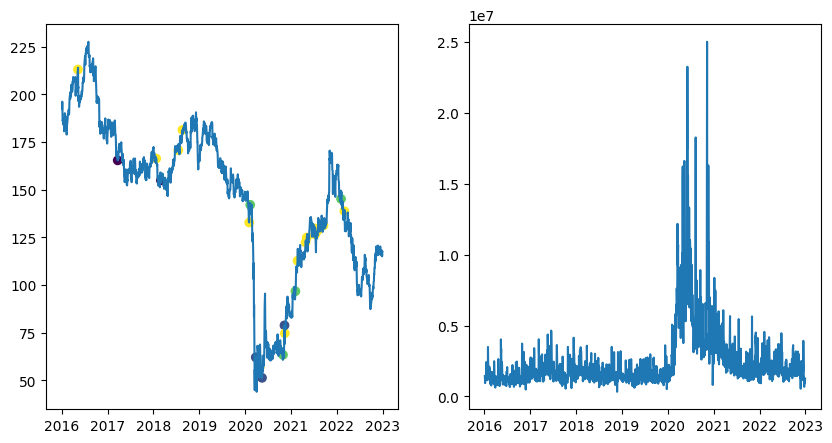

In [63]:
jimOverTimePlot(dfS)

In [67]:
scaler = MinMaxScaler()
dfS['price'] = scaler.fit_transform(np.expand_dims(dfS['price'].values, axis=1))
dfS['volume'] = scaler.fit_transform(np.expand_dims(dfS['volume'].values, axis=1))
dfS

,date,price,volume,call
3,2016-01-04,0.807942,0.045197,None
4,2016-01-05,0.828803,0.036723,None
5,2016-01-06,0.826189,0.024775,None
6,2016-01-07,0.803693,0.038722,None
7,2016-01-08,0.773953,0.043263,None
...,...,...,...,...
2548,2022-12-23,0.402527,0.014170,None
2552,2022-12-27,0.403562,0.036630,None
2553,2022-12-28,0.387004,0.026474,None
2554,2022-12-29,0.399314,0.026032,None
